In [ ]:
# How to setup d2l environment
# 1. Prepare machine, e.g. AWS EC2 instance
# 2. Install Miniconda according to the machine's Python version
#    > conda init
#    > bash
# 3. Setup conda environment using Python3.9 which is what d2l 
#    was tested on
#    > conda create d2l python==3.9
# 4. Install dependencies in conda env, i.e. torch, torchvision
#    > conda activate d2l
# 5. Download d2l notebooks
# 6. Start Jupyter notebook in d2l/pytorch
# 7. In another window, do ssl tunneling which forward all requests
#    to local port to the specified port on remote machine
#    > ssh -i rsa.pem -L 8888:localhost:8888 user@remote_ip
# 8. Open notebook link in local browser, test
#    > import torch
#    > from d2l import torch as d2l

In [10]:
import random
import torch
from d2l import torch as d2l

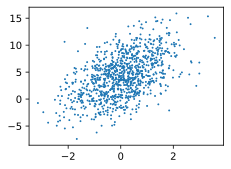

In [65]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape([-1, 1])

true_w = torch.tensor([2., -3.4])
true_b = torch.tensor(4.2)
features, labels = synthetic_data(true_w, true_b, 1000)

# print(f'features: {features}, \nlabels: {labels}')

d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().numpy(),
                labels.detach().numpy(), 1)

In [23]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # Use same seed to control order of examples
    random.shuffle(indices)
    
    start = 0
    while start < num_examples:
        end = min(start + batch_size, num_examples)
        batch = torch.tensor(indices[start:end])
        start = end
        yield features[batch], labels[batch]
        
batch_size = 15

for X, y in data_iter(batch_size, features, labels):
    print(f'{X}\n{y}')
    break

tensor([[-0.2509,  0.0751],
        [ 1.1259,  1.2865],
        [ 1.5046, -0.3728],
        [-0.3739, -1.5634],
        [-1.1053,  0.1135],
        [-0.3732, -0.1368],
        [ 1.8717,  0.1591],
        [ 0.1889, -1.2040],
        [-0.2771,  1.8089],
        [ 0.9924,  1.8709],
        [-0.2511, -0.0206],
        [-0.8912, -0.2023],
        [-0.4477,  0.7609],
        [ 1.1022, -0.9804],
        [-1.4115, -2.0593]])
tensor([[ 3.4279],
        [ 2.0587],
        [ 8.4742],
        [ 8.7614],
        [ 1.5987],
        [ 3.9285],
        [ 7.3851],
        [ 8.6591],
        [-2.5044],
        [-0.1834],
        [ 3.7635],
        [ 3.1205],
        [ 0.7185],
        [ 9.7323],
        [ 8.3676]])


In [60]:
# Linear regression model from scratch

def linreg(X, w, b):
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    return ((y_hat - y.reshape(y_hat.shape)) ** 2).sum() * 0.5

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def fit(w, b, lr, epoch, batch_size, features, labels):
    for e in range(epoch):
        for X, y in data_iter(batch_size, features, labels):
            y_hat = net(X, w, b)
            l = loss(y_hat, y)
            l.backward()
            sgd([w, b], lr, len(y_hat))
        print(f'epoch {e}, loss {l / len(y_hat):5f}')
    return w, b

lr = 0.03
epoch = 3
batch_size = 10
net = linreg
loss = squared_loss

w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

w, b = fit(w, b, lr, epoch, batch_size, features, labels)
print(f'true_w: {true_w}\ntrue_b: {true_b}')
print(f'w: {w}\nb: {b}')

epoch 0, loss 0.051191
epoch 1, loss 0.000139
epoch 2, loss 0.000035
true_w: tensor([ 2.0000, -3.4000])
true_b: 4.199999809265137
w: tensor([[ 2.0004],
        [-3.4002]], requires_grad=True)
b: tensor([4.1992], requires_grad=True)


In [70]:
# Linear regression model using torch api

from torch.utils import data

def load_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

lr = 0.03
batch_size = 10
epoch = 5
# next(iter(load_data([features, labels], batch_size)))

from torch import nn
net = nn.Sequential(nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

for e in range(epoch):
    for X, y in load_data([features, labels], batch_size):
        l = loss(net(X), y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    test_l = loss(net(features), labels)
    print(f'epoch {e}, loss {test_l:5f}')
    
print(f'w: {net[0].weight.data}\nb: {net[0].bias.data}')

epoch 0, loss 0.000204
epoch 1, loss 0.000101
epoch 2, loss 0.000101
epoch 3, loss 0.000102
epoch 4, loss 0.000101
w: tensor([[ 1.9995, -3.4004]])
b: tensor([4.1998])
